In [123]:
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras.models import load_model
# from extra_keras_datasets import usps
import usps.usps as usps
import matplotlib.pyplot as plt

In [2]:
def loaddata(traindatasettype, testdatasettype, start_samples):
    if traindatasettype == 'mnist':
        (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
        x_train = (x_train[(y_train == 5) | (y_train == 7),]- 127.5) / 127.5
        x_train = np.expand_dims(x_train, axis=3)
        y_train = y_train[(y_train == 5) | (y_train == 7)]
        y_train = np.where(y_train == 5, 0, 1).reshape((-1,1))

        if testdatasettype == 'mnist':
            x_test = (x_test[(y_test == 5) | (y_test == 7),]- 127.5) / 127.5
            x_test = np.expand_dims(x_test, axis=3)
            y_test = y_test[(y_test == 5) | (y_test == 7)]
            y_test = np.where(y_test == 5, 0, 1).reshape((-1,1))

        elif testdatasettype == 'usps':
            (x_test, y_test), (_, _) = usps.load_data()

            y_test = y_test.astype('int')
            x_test = x_test[(y_test == 5) | (y_test == 7),]
            x_test = np.expand_dims(x_test, axis=3)
            x_test = (x_test + 1) / 2
            x_test = tf.image.pad_to_bounding_box(x_test,4,4,24,24)
            x_test = tf.image.resize(x_test, [28,28])
            x_test = (x_test * 2) - 1

            y_test = y_test[(y_test == 5) | (y_test == 7)]
            y_test = np.where(y_test == 5, 0, 1).reshape((-1,1))

    elif traindatasettype == 'cifar10' and testdatasettype == 'cifar10':
        (x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
        y_train = np.squeeze(y_train)
        y_test = np.squeeze(y_test)
        x_train = (x_train[(y_train == 1) | (y_train == 7),]- 127.5) / 127.5
        y_train = y_train[(y_train == 1) | (y_train == 7)]
        y_train = np.where(y_train == 1, 0, 1).reshape((-1,1))

        x_test = (x_test[(y_test == 1) | (y_test == 7),]- 127.5) / 127.5
        y_test = y_test[(y_test == 1) | (y_test == 7)]
        y_test = np.where(y_test == 1, 0, 1).reshape((-1,1))

    # np.random.seed(0)
    rand_idx = np.random.choice(np.arange(x_train.shape[0]), size = start_samples, replace = False)
    x_train = x_train[rand_idx]
    y_train = y_train[rand_idx]

    return x_train, y_train, x_test, y_test


In [3]:
x_train, y_train, x_test, y_test = loaddata('mnist','mnist',50)

In [5]:
def trainsvc(xtrain, ytrain):
    x = np.squeeze(xtrain)
    xt = x.reshape((x.shape[0],-1))
    svc = SVC(kernel='linear', gamma=0.001).fit(xt, ytrain.ravel())
    return svc

svc = trainsvc(x_train, y_train)

In [51]:
def loadgenerator(generatorpath):
    generator = load_model(generatorpath)
    generator.trainable = False
    return generator

generator = loadgenerator('./gans/mnist/generator_model_1000.h5')

In [8]:
def loadoracle(oraclepath):
    oracle = load_model(oraclepath)
    oracle.trainable = False
    return oracle

oracle = loadoracle('./oracles/mnist57.h5')

In [100]:
n_samples_end = 350
latent_dim = 100
traindatasettype = 'mnist'
L = 0.0001

x_test = np.squeeze(x_test)
x_test = x_test.reshape((x_test.shape[0],-1))

y_test = y_test.ravel()

learner_acc = []
n_samples = []

n_samples.append(x_train.shape[0])

n_samples_this = x_train.shape[0]

svc = trainsvc(x_train, y_train)
svc_preds = svc.predict(x_test)
acc = accuracy_score(y_test, svc_preds)
print(f'Classifier Accuracy Start: {acc}')
learner_acc.append(acc)

Classifier Accuracy Start: 0.9661458333333334


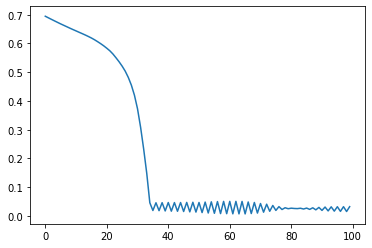

In [154]:

# while n_samples_this < n_samples_end:
    # train an svc using the training set
    
w = svc.coef_
b = svc.intercept_

w = tf.cast(tf.reshape(tf.Variable(w), [-1]), tf.float32)
b = tf.cast(tf.Variable(b), tf.float32)

z = np.random.randn(100).reshape((1,-1))
z = tf.Variable(z)

x_train_flat = tf.keras.layers.Flatten()(tf.Variable(x_train, dtype=tf.dtypes.float32))


opt = tf.keras.optimizers.SGD()
losstrack = []

for _ in range(100):
    with tf.GradientTape() as tape:
        # Forward pass
        tape.watch(z)
        f = generator(z)
        f = tf.reshape(f, [-1])
        dot = tf.tensordot(f, w, 1) + b

        ones = tf.ones(x_train_flat.shape[0], dtype=tf.dtypes.float32)
        ff = tf.tensordot(ones, f, axes = 0)
        d = x_train_flat - ff
        dd = tf.reduce_mean(tf.math.reduce_euclidean_norm(d, 1))

        loss = tf.norm(dot) - 0.001 * dd
        losstrack.append(loss)
        
    # Calculate gradients with respect to every trainable variable
    grad = tape.gradient(loss, z)
    
    opt.apply_gradients(zip([grad], [z]))

zt = z.numpy()
gen = generator.predict(zt)

plt.plot(losstrack)
